# CVIP-project-1

Find the intrinsic and extrinsic parameters of a camera using an image of a chessboard.

We are given an image of a chessboard. The edge length of each grid on the chessboard is $10 \text{ mm}$ in real world. Suppose the length of each pixel in the image is $1 \text{ mm}$. Find the projection matrix {eq}`projection_matrix` of the camera using the 32 corners of the chessboard.

Tasks:
* Design a function to get the image coordinates of the 32 corners from the image. You can decide the order of output points for yourself.
* Manually (or design a program) to get the world coordinate of the 32 corners. Note that the output order should be the SAME with the last question.
* Design a function to get the intrinsic parameters $f_x, f_y, o_x, o_y$ from the image coordinates and world coordinates acquired above.
* Design a function to get the extrinsic parameters $R$, $T$ from the image coordinates and world coordinates acquired above.

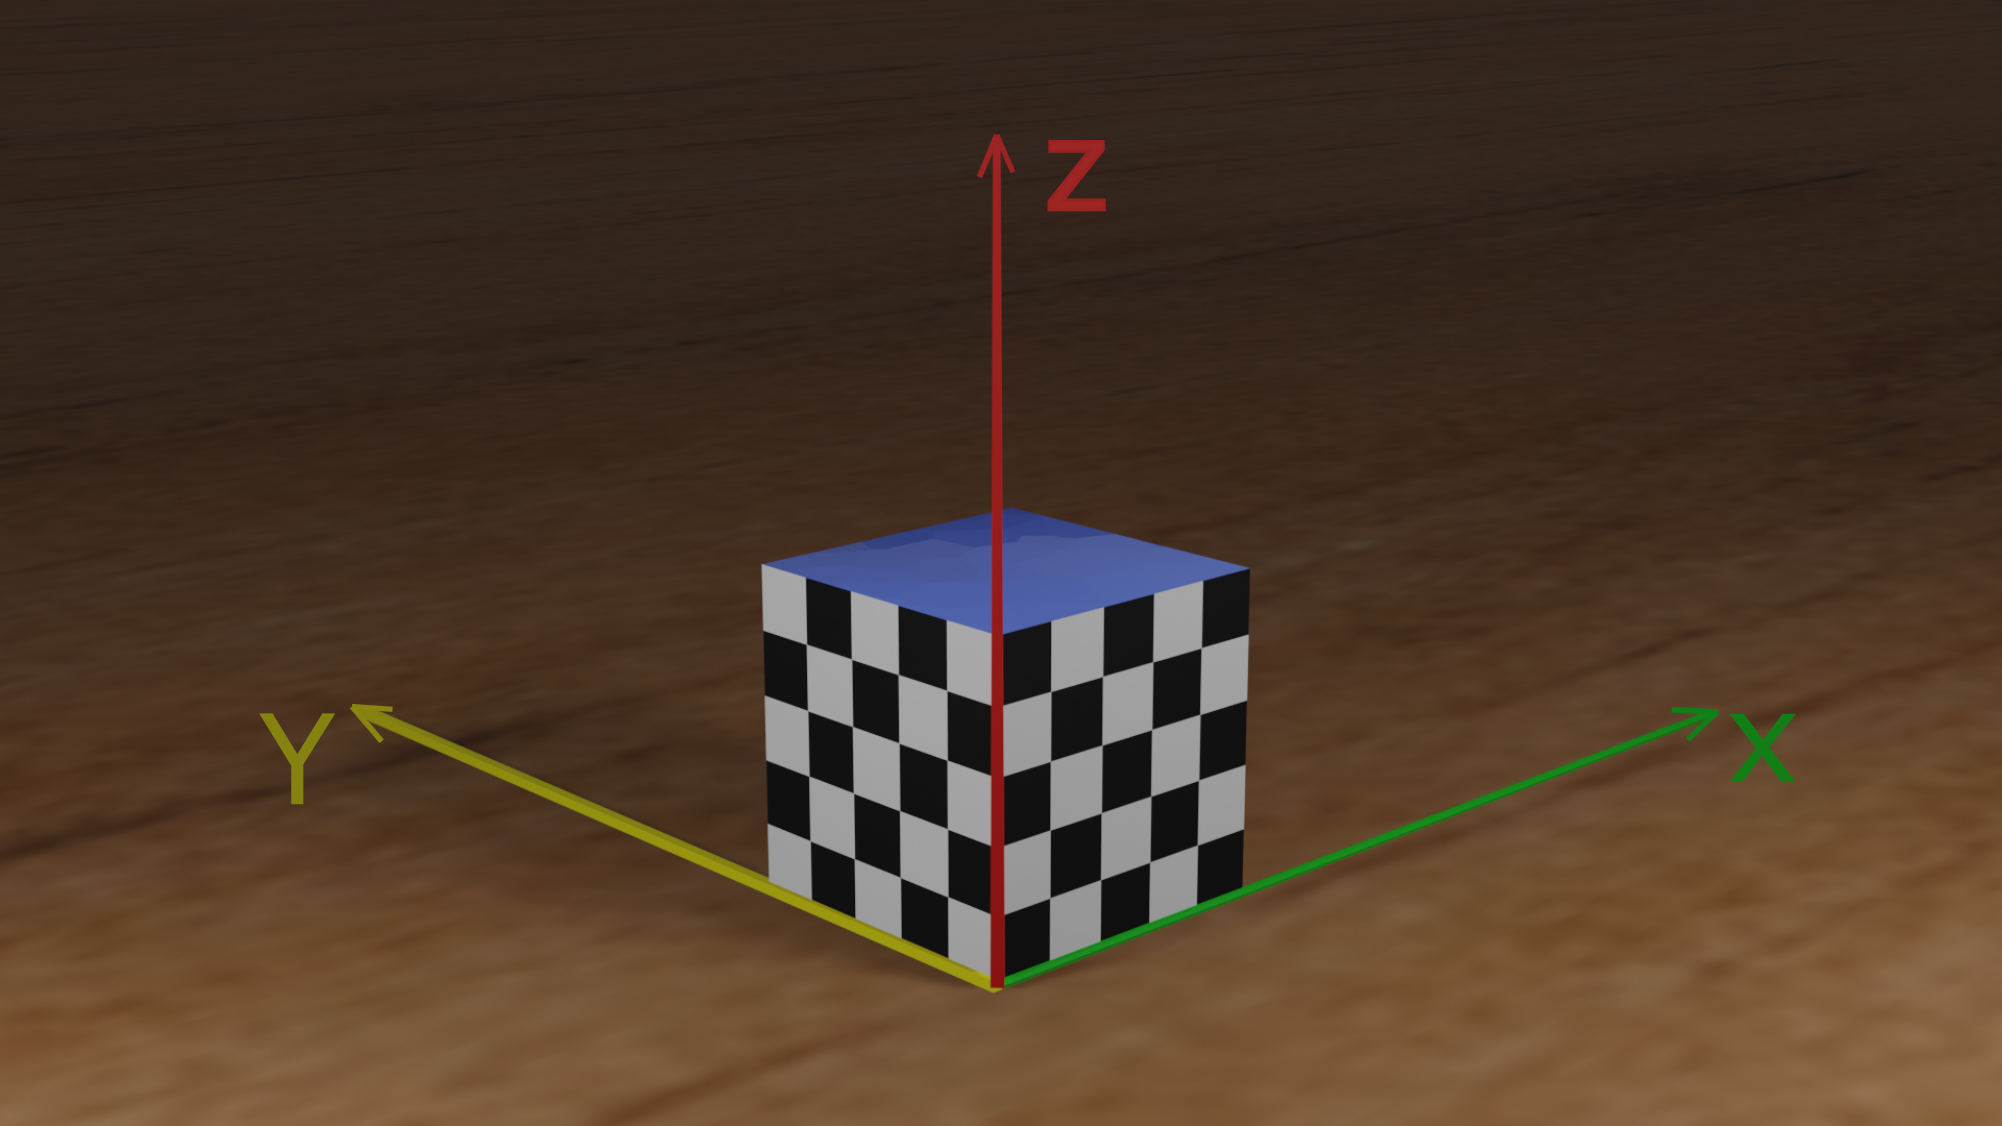

In [2]:
import numpy as np
from typing import List, Tuple
import cv2
from google.colab.patches import cv2_imshow

from cv2 import cvtColor, COLOR_BGR2GRAY, TERM_CRITERIA_EPS, TERM_CRITERIA_MAX_ITER, \
    findChessboardCorners, cornerSubPix, drawChessboardCorners

'''
Please do Not change or add any imports. 
'''

img_given = cv2.imread('checkboard.png')
cv2_imshow(img_given)

In [ ]:
from cv2 import cvtColor, COLOR_BGR2GRAY, TERM_CRITERIA_EPS, TERM_CRITERIA_MAX_ITER, \
    findChessboardCorners, cornerSubPix, drawChessboardCorners
    
def find_corner_img_coord(image: np.ndarray) -> np.ndarray:
    '''
    Args: 
        image: Input image of size MxNx3. M is the height of the image. N is the width of the image. 3 is the channel of the image.
    Return:
        A numpy array of size 32x2 that represents the 32 checkerboard corners' pixel coordinates. 
        The pixel coordinate is defined such that the of top-left corner is (0, 0) and the bottom-right corner of the image is (N, M). 
    '''
    img_coord = np.zeros([32, 2], dtype=float)

    # Your implementation

    # Converting the image to grayscale
    image = cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Using findChessboardCorners function to find the coordinates of corners of chess board. Filter size = (4,9)
    ret, coords = findChessboardCorners(image = image, patternSize = (4,9)) # Finding the chessboard corners.
    image2 = drawChessboardCorners(image,(4,9),coords,ret) # drawing the chessboard corners

    # reshaping the output from findChessboardCorners
    coords = coords.reshape((36,2))

    # As the filter size is (4,9) we receive the edge coordinates of the chessboard also. We need to exclude those coordinates
    corners_to_rem = [16,17,18,19] # Corners to remove

  
    required_corners = []
    for n,i in enumerate(coords):
      if n not in corners_to_rem:
        required_corners.append(i)
    
    # required image coords
    img_coord = np.array(required_corners)    


    return img_coord

In [ ]:
image = cv2.imread('checkboard.png')
img_coord = find_corner_img_coord(image)

In [ ]:
def find_corner_world_coord(img_coord: np.ndarray) -> np.ndarray:
    '''
    You can output the world coord manually or through some algorithms you design. Your output should be the same order with img_coord.
    Args: 
        img_coord: The image coordinate of the corners. Note that you do not required to use this as input, 
        as long as your output is in the same order with img_coord.
    Return:
        A numpy array of size 32x3 that represents the 32 checkerboard corners' pixel coordinates. 
        The world coordinate or each point should be in form of (x, y, z). 
        The axis of the world coordinate system are given in the image. The output results should be in milimeters.
    '''
    world_coord = np.zeros([32, 3], dtype=float)

    # Your implementation

    corners_from_image = [[40,0,40], [40,0,30], [40,0,20], [40,0,10], [30,0,40], [30,0,30], [30,0,20], [30,0,10], [20,0,40], [20,0,30],
           [20,0,20], [20,0,10], [10,0,40], [10,0,30], [10,0,20], [10,0,10], [0,10,40], [0,10,30], [0,10,20], [0,10,10],
           [0,20,40], [0,20,30], [0,20,20], [0,20,10], [0,30,40], [0,30,30], [0,30,20], [0,30,10], [0,40,40], [0,40,30],
           [0,40,20], [0,40,10]]


    world_coord = np.array(corners_from_image,dtype=float)
    return world_coord

In [ ]:
world_coord = find_corner_world_coord(image)

In [ ]:
def find_intrinsic(img_coord: np.ndarray, world_coord: np.ndarray) -> Tuple[float, float, float, float]:
    '''
    Use the image coordinates and world coordinates of the 32 point to calculate the intrinsic parameters.
    Args: 
        img_coord: The image coordinate of the 32 corners. This is a 32x2 numpy array.
        world_coord: The world coordinate of the 32 corners. This is a 32x3 numpy array.
    Returns:
        fx, fy: Focal length. 
        (cx, cy): Principal point of the camera (in pixel coordinate).
    '''

    fx: float = 0
    fy: float = 0
    cx: float = 0
    cy: float = 0

    # As we have 32 corner points, we need to create a matrix of size (2*n,12)
    matrix = np.zeros((64,12))

    for i in range(0,len(matrix)):
      
      if i % 2 == 0 : 
        matrix[i] = [world_coord[i//2][0],world_coord[i//2][1],world_coord[i//2][2],1,0,0,0,0,(-img_coord[i//2][0] * world_coord[i//2][0]),(-img_coord[i//2][0] * world_coord[i//2][1]),(-img_coord[i//2][0] * world_coord[i//2][2]),-img_coord[i//2][0]]
      else:
        matrix[i] = [0,0,0,0,world_coord[i//2][0],world_coord[i//2][1],world_coord[i//2][2],1,(-img_coord[i//2][1] * world_coord[i//2][0]),(-img_coord[i//2][1] * world_coord[i//2][1]),(-img_coord[i//2][1] * world_coord[i//2][2]),-img_coord[i//2][1]]
    
    matrix = np.array(matrix,dtype = float) 

    # Singular Value Decomposition of matrix

    u,s,vh = np.linalg.svd(matrix)
    vh = vh.reshape((12,12))

    # As per preliminary, we need to take the last row of V.T

    """
    According to preliminary, (r_i).T.dot(r_j)=I
    """

    right_matrix =np.reshape(vh[11],(3,4))
    last_row_of_x = right_matrix[2,0:3] 
    norm_of_x = np.linalg.norm(last_row_of_x)
    right_matrix_scaled = right_matrix/norm_of_x

    m11,m12,m13,m14,m21,m22,m23,m24,m31,m32,m33,m34 = tuple(right_matrix_scaled.flatten())

    m1 = np.array([[m11],[m12],[m13]])
    m2 = np.array([[m21],[m22],[m23]])
    m3 = np.array([[m31],[m32],[m33]])
    m4 = np.array([[m14],[m24],[m34]])


    # Solving for c_x and c_y

    cx = np.dot(m1.T,m3)[0][0]
    cy = np.dot(m2.T,m3)[0][0]

    # Solving for f_x and f_y

    temp1 = np.dot(m1.T,m1)[0][0]
    temp2 = cx**2

    fx = np.sqrt(temp1 - temp2)

    temp1 = np.dot(m2.T,m2)[0][0]
    temp2 = cy**2

    fy = np.sqrt(temp1 - temp2)

    return fx, fy, cx, cy


In [ ]:
fx,fy,cx,cy = find_intrinsic(img_coord= img_coord, world_coord= world_coord)

In [ ]:
print(fx,fy,cx,cy)

2899.782584460298 2894.249603657043 922.7449326469593 510.0915608810428


In [ ]:
def find_extrinsic(img_coord: np.ndarray, world_coord: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    '''
    Use the image coordinates, world coordinates of the 32 point and the intrinsic parameters to calculate the extrinsic parameters.
    Args: 
        img_coord: The image coordinate of the 32 corners. This is a 32x2 numpy array.
        world_coord: The world coordinate of the 32 corners. This is a 32x3 numpy array.
    Returns:
        R: The rotation matrix of the extrinsic parameters. It is a 3x3 numpy array.
        T: The translation matrix of the extrinsic parameters. It is a 1-dimensional numpy array with length of 3.
    '''

    R = np.eye(3).astype(float)
    T = np.zeros(3, dtype=float)

    # Your implementation


    # Using the intrinsic parameters from the find_intrinsic function

    fx,fy,cx,cy = find_intrinsic(img_coord,world_coord)

    # Calculating the M matrix

    matrix = np.zeros((64,12))
    for i in range(0,len(matrix)):
      
      if i % 2 == 0 : 
        matrix[i] = [world_coord[i//2][0],world_coord[i//2][1],world_coord[i//2][2],1,0,0,0,0,(-img_coord[i//2][0] * world_coord[i//2][0]),(-img_coord[i//2][0] * world_coord[i//2][1]),(-img_coord[i//2][0] * world_coord[i//2][2]),-img_coord[i//2][0]]
      else:
        matrix[i] = [0,0,0,0,world_coord[i//2][0],world_coord[i//2][1],world_coord[i//2][2],1,(-img_coord[i//2][1] * world_coord[i//2][0]),(-img_coord[i//2][1] * world_coord[i//2][1]),(-img_coord[i//2][1] * world_coord[i//2][2]),-img_coord[i//2][1]]
    
    matrix = np.array(matrix,dtype = float) 


    u,s,vh = np.linalg.svd(matrix)
    vh = vh.reshape((12,12))

    """
    According to preliminary, (r_i).T.dot(r_j)=I
    """

    right_matrix =np.reshape(vh[11],(3,4))
    last_row_of_x = right_matrix[2,0:3] 
    norm_of_x = np.linalg.norm(last_row_of_x)
    right_matrix_scaled = right_matrix/norm_of_x

    m11,m12,m13,m14,m21,m22,m23,m24,m31,m32,m33,m34 = tuple(right_matrix_scaled.flatten())

    r11 = (m11 - (cx*m31))/fx
    r12 = (m12 - (cx*m32))/fx
    r13 = (m13 - (cx*m33))/fx
    r21 = (m21 - (cy*m31))/fy
    r22 = (m22 - (cy*m32))/fy
    r23 = (m23 - (cy*m33))/fy
    r31 = m31
    r32 = m32
    r33 = m33

    temp1 = (m14 -(cx*m34))/fx
    temp2 = (m24 -(cy*m34))/fy
    temp3 = m34

    R = [[r11,r12,r13],[r21,r22,r23],[r31,r32,r33]]
    R = np.array(R,dtype = float)
    T = [temp1,temp2,temp3]
    T = np.array(T,dtype = float)

    return R, T

In [ ]:
R,T

(array([[-0.74430412,  0.66782761,  0.00420261],
        [ 0.17239635,  0.18117831,  0.96822204],
        [-0.6458474 , -0.72137998,  0.24998412]]),
 array([ -10.18222715,  -65.3073362 , -398.07365307]))

In [ ]:
R,T = find_extrinsic(img_coord,world_coord)

In [ ]:
def find_corner_img_coord1(image: np.ndarray) -> np.ndarray:
    '''
    Args: 
        image: Input image of size MxNx3. M is the height of the image. N is the width of the image. 3 is the channel of the image.
    Return:
        A numpy array of size 32x2 that represents the 32 checkerboard corners' pixel coordinates. 
        The pixel coordinate is defined such that the of top-left corner is (0, 0) and the bottom-right corner of the image is (N, M). 
    '''
    img_coord = np.zeros([32, 2], dtype=float)

    img = cvtColor(image,cv2.COLOR_BGR2GRAY) # RGB 2 GRAY

    np.random.seed(123)

    # cv2_imshow(img)
    ret, coords = findChessboardCorners(image = image, patternSize = (4,9)) # Finding the chessboard corners.
    coords = coords.reshape((36,2))
    # img2 = drawChessboardCorners(img,(4,9),coords,ret) # drawing the chessboard corners


    # To find the orders of the coords identified.
    # n=0
    # for i in range(0,36):
    #     img2=cv2.putText(img2,str(n), (int(coords[i,0]),int(coords[i,1])),cv2.FONT_HERSHEY_SIMPLEX,fontScale = 0.5,color = (250,225,100))
    #     n+=1
    # cv2_imshow(img2)    


    # Process of removing the centre corners.
    index = [16,17,18,19] # Corners to remove 
    res = []
    for n,i in enumerate(coords):
      if n not in index:
        res.append(i)


    # required image coords
    img_coord = np.array(res)


  # Printing the new updated corners
    # n= 0 
    # for i in range(0,32):
    #     img3=cv2.putText(image,str(n), (int(img_coord[i,0]),int(img_coord[i,1])),cv2.FONT_HERSHEY_SIMPLEX,fontScale = 0.5,color = (250,225,100))
    #     n+=1
    # cv2_imshow(img3)

    return img_coord

In [ ]:
image = cv2.imread('checkboard.png')
find_corner_img_coord1(image)

array([[1201.5233 ,  647.49817],
       [1200.0327 ,  714.4305 ],
       [1197.5353 ,  781.14886],
       [1197.4014 ,  845.0851 ],
       [1152.975  ,  662.1383 ],
       [1152.6964 ,  728.20416],
       [1150.7375 ,  796.05316],
       [1150.7269 ,  860.9512 ],
       [1102.4392 ,  676.48883],
       [1102.2838 ,  745.3369 ],
       [1100.3595 ,  813.79645],
       [1100.5236 ,  879.6722 ],
       [1052.     ,  694.     ],
       [1050.5052 ,  761.0988 ],
       [1049.9686 ,  830.1625 ],
       [1049.2822 ,  898.77264],
       [ 947.6249 ,  691.5359 ],
       [ 946.70715,  760.6685 ],
       [ 946.4651 ,  828.0008 ],
       [ 947.9157 ,  896.9777 ],
       [ 897.721  ,  675.10657],
       [ 899.63495,  743.915  ],
       [ 899.81396,  810.4296 ],
       [ 900.4624 ,  877.58014],
       [ 852.56903,  660.28613],
       [ 852.61505,  726.3382 ],
       [ 852.465  ,  791.997  ],
       [ 854.46985,  858.74805],
       [ 806.7401 ,  644.0146 ],
       [ 806.76776,  709.82117],
       [ 8

In [ ]:
full_image_corners

array([[1201.5233 ,  647.49817],
       [1200.0327 ,  714.4305 ],
       [1197.5353 ,  781.14886],
       [1197.4014 ,  845.0851 ],
       [1152.975  ,  662.1383 ],
       [1152.6964 ,  728.20416],
       [1150.7375 ,  796.05316],
       [1150.7269 ,  860.9512 ],
       [1102.4392 ,  676.48883],
       [1102.2838 ,  745.3369 ],
       [1100.3595 ,  813.79645],
       [1100.5236 ,  879.6722 ],
       [1052.     ,  694.     ],
       [1050.5052 ,  761.0988 ],
       [1049.9686 ,  830.1625 ],
       [1049.2822 ,  898.77264],
       [ 947.6249 ,  691.5359 ],
       [ 946.70715,  760.6685 ],
       [ 946.4651 ,  828.0008 ],
       [ 947.9157 ,  896.9777 ],
       [ 897.721  ,  675.10657],
       [ 899.63495,  743.915  ],
       [ 899.81396,  810.4296 ],
       [ 900.4624 ,  877.58014],
       [ 852.56903,  660.28613],
       [ 852.61505,  726.3382 ],
       [ 852.465  ,  791.997  ],
       [ 854.46985,  858.74805],
       [ 806.7401 ,  644.0146 ],
       [ 806.76776,  709.82117],
       [ 8

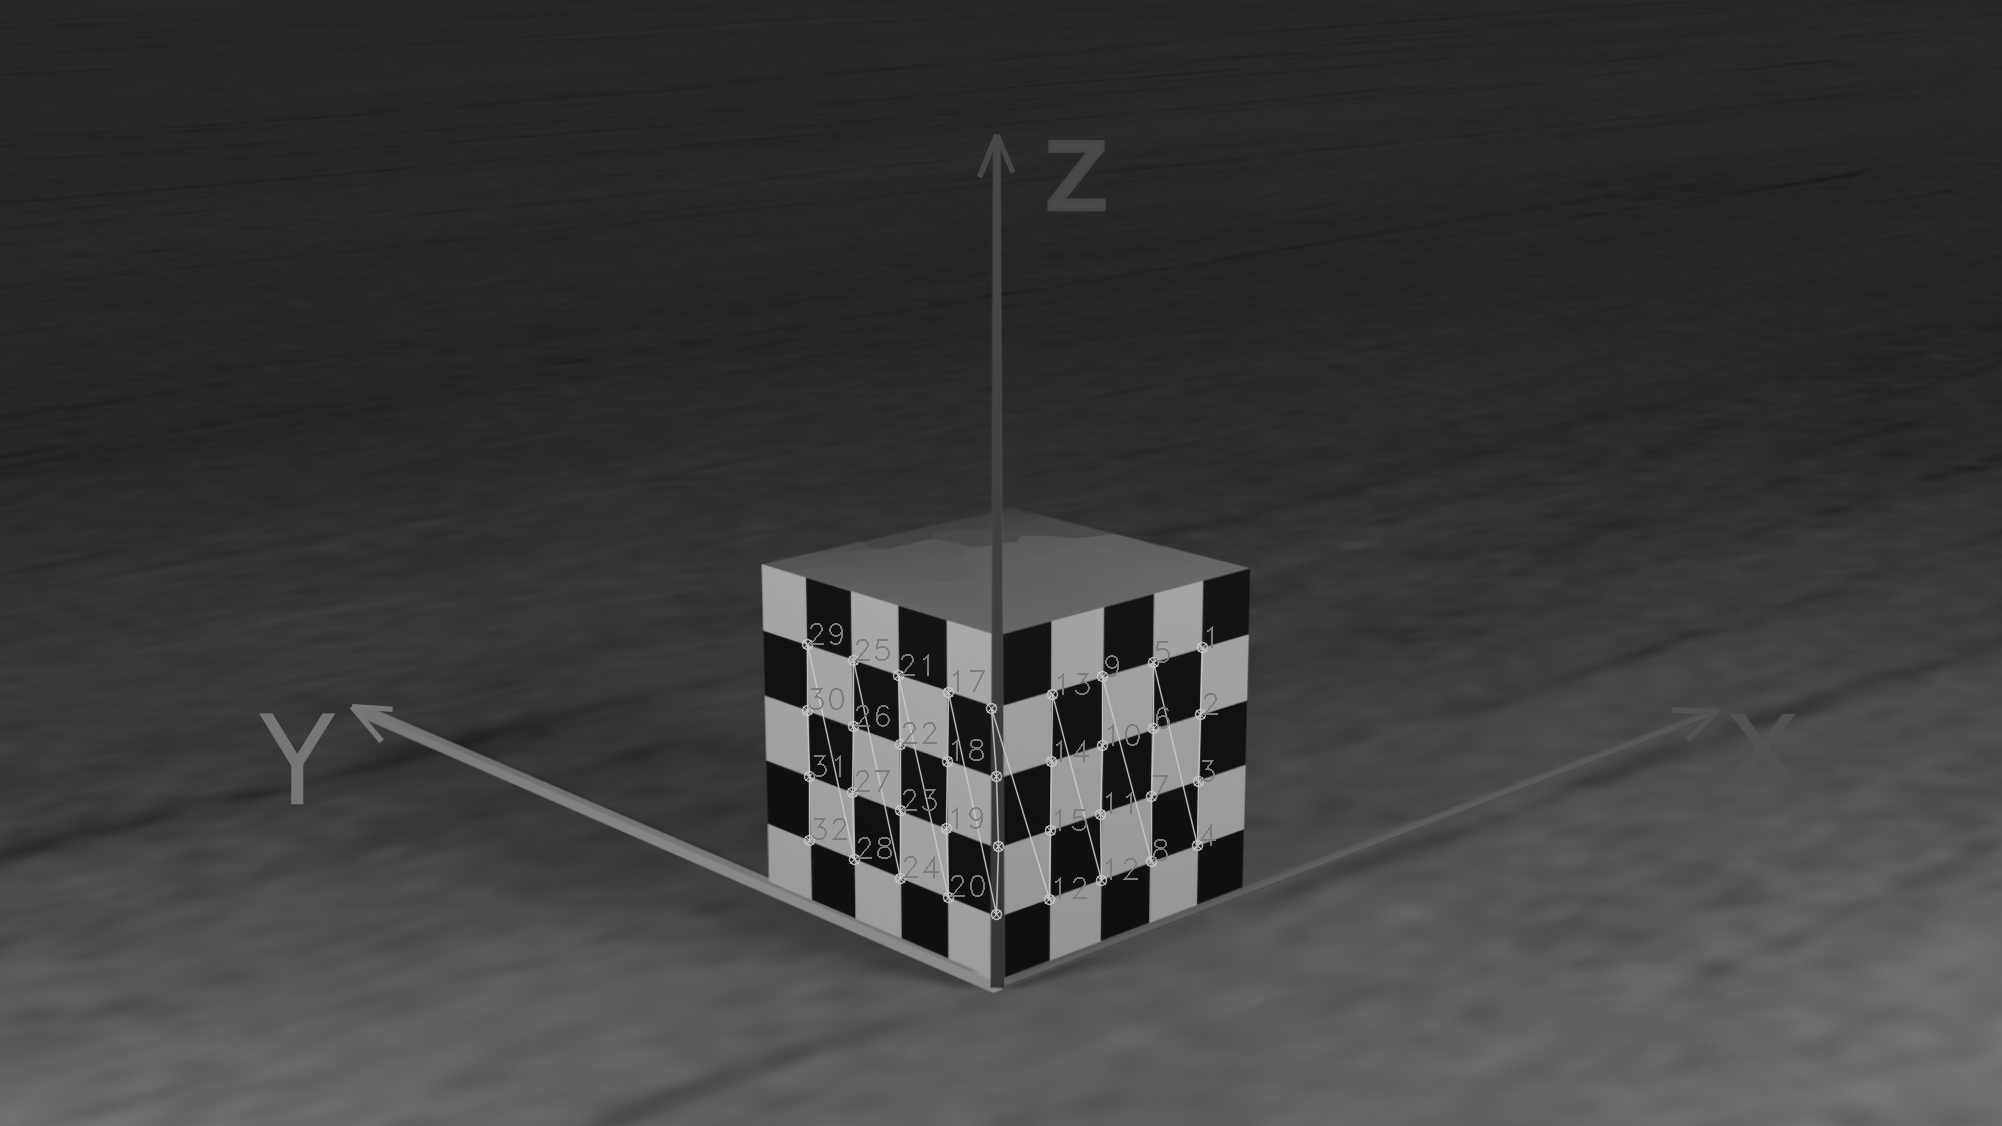

In [ ]:
image = cv2.imread('checkboard.png')
image_grayed = cvtColor(image, COLOR_BGR2GRAY)

def full_image(image, filter  = (4,9), text_params = {
    'fontFace' : cv2.FONT_HERSHEY_DUPLEX,
    'fontScale' : 1,
    'color' : (125, 246, 55),
    'thickness' : 3
}):
  frames, frame_corners = findChessboardCorners(image_grayed, filter)
  image_with_corners = drawChessboardCorners(image_grayed, filter, frame_corners, frames)

  image_with_text = image_grayed.copy()

  rem_corners = [16,17,18,19]

  for i in range(len(frame_corners)):
    if i not in rem_corners:
      if i>=15:
        image_with_text = cv2.putText(img = image_with_text, text = str(i-3), org = (int(frame_corners[i][0][0]), int(frame_corners[i][0][1])), fontFace = text_params['fontFace'], fontScale = text_params['fontScale'], color=text_params['color'], thickness = 1)
      else:
        image_with_text = cv2.putText(img = image_with_text, text = str(i+1), org = (int(frame_corners[i][0][0]), int(frame_corners[i][0][1])), fontFace = text_params['fontFace'], fontScale = text_params['fontScale'], color=text_params['color'], thickness = 1)

  cv2_imshow(image_with_text)

  frame_corners = frame_corners.reshape(36,2)

  final_corners = np.concatenate((frame_corners[:16], frame_corners[20:]))

  return final_corners

full_image_corners = full_image(image_grayed)

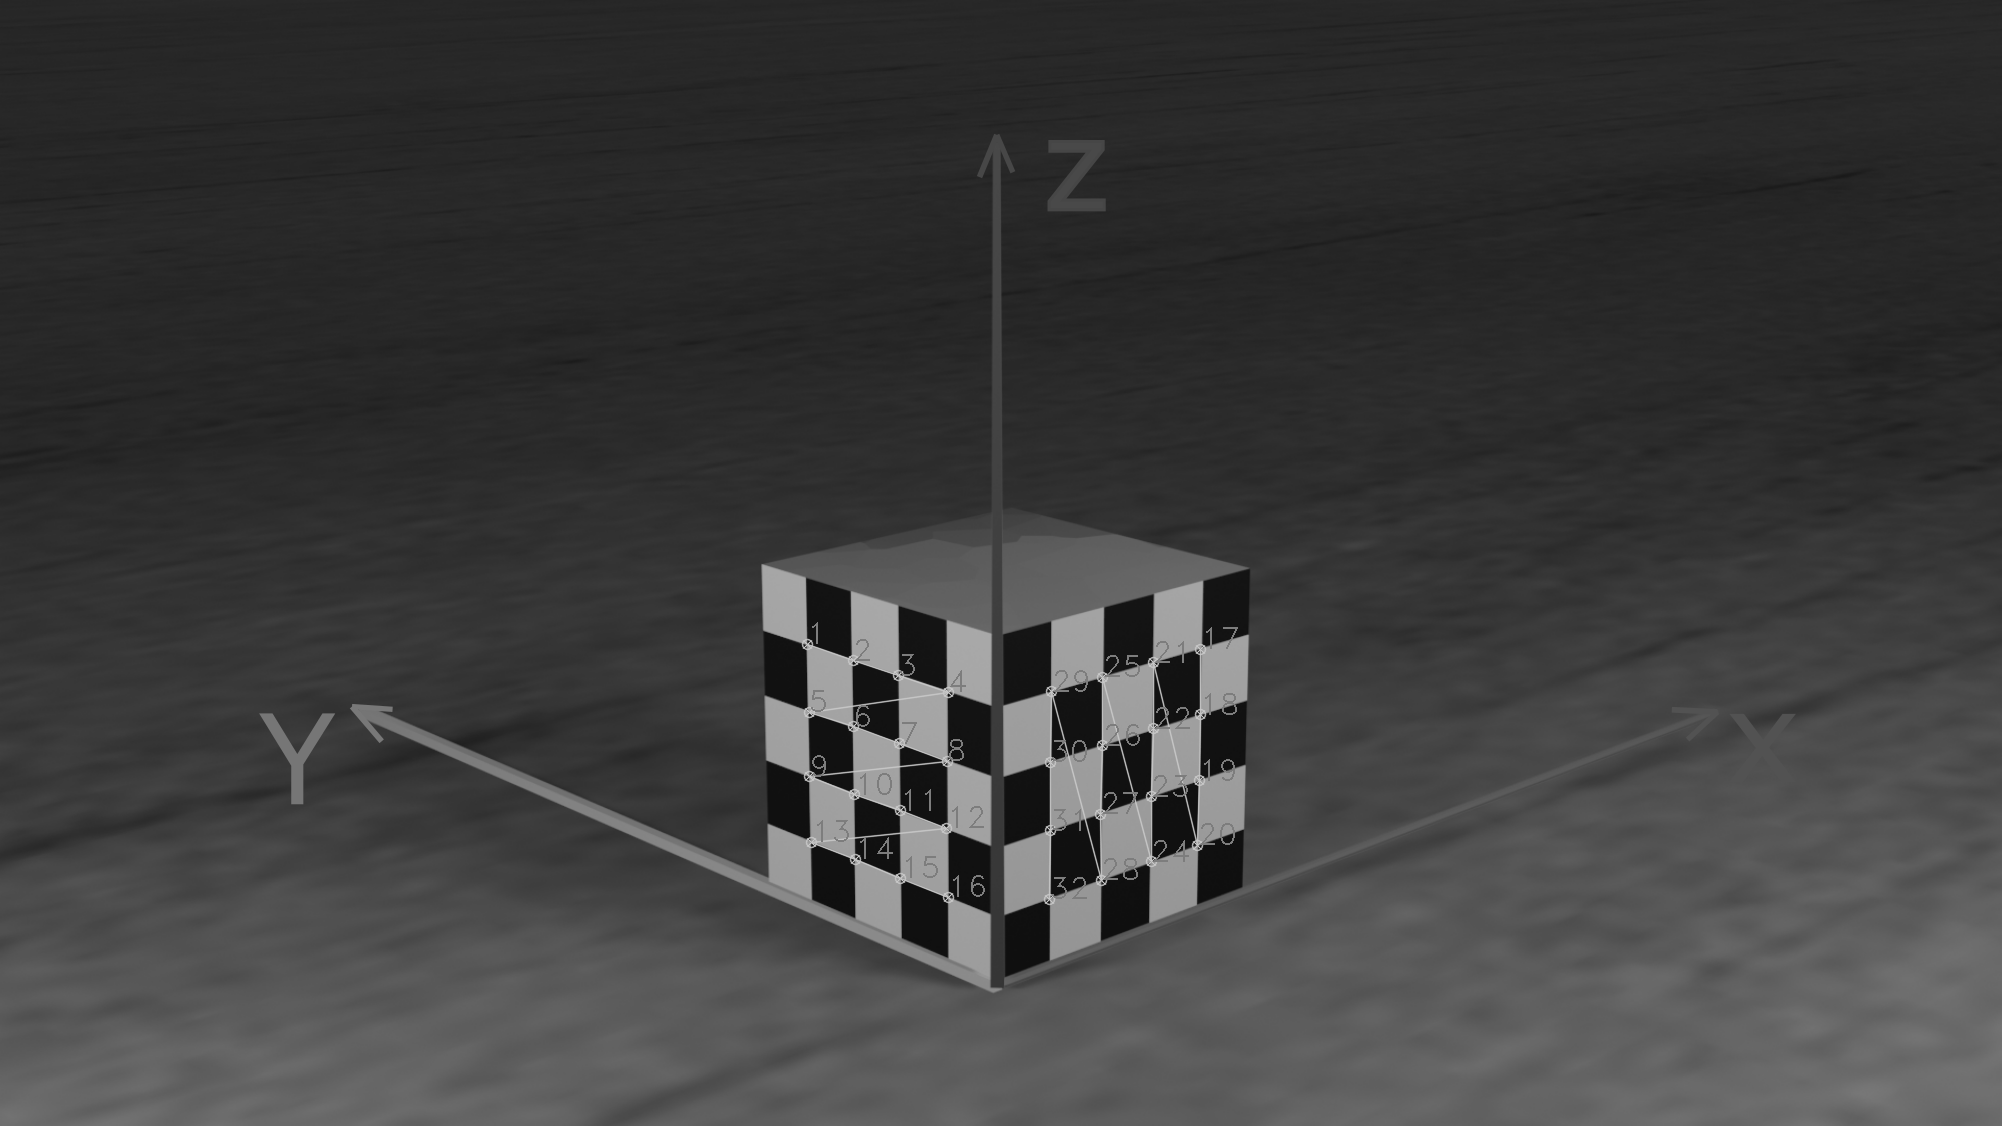

In [ ]:
image = cv2.imread('checkboard.png')
image_grayed = cvtColor(image, COLOR_BGR2GRAY)
def split_attach(image, filter  = (4,4), text_params = {
    'fontFace' : cv2.FONT_HERSHEY_DUPLEX,
    'fontScale' : 1,
    'color' : (125, 246, 55),
    'thickness' : 3
}):
  
  image_left = image_grayed[:, :int(image_grayed.shape[1]/2)]
  frames_l, frame_corners_l = findChessboardCorners(image_left, filter)
  image_with_corners_l = drawChessboardCorners(image_left, filter, frame_corners_l, frames_l)

  image_with_text_l = image_with_corners_l.copy()

  # rem_corners = [16,17,18,19]

  for i in range(len(frame_corners_l)):
    image_with_text = cv2.putText(img = image_with_text_l, text = str(i+1), org = (int(frame_corners_l[i][0][0]), int(frame_corners_l[i][0][1])), fontFace = text_params['fontFace'], fontScale = text_params['fontScale'], color=text_params['color'], thickness = 1)

  # cv2_imshow(image_with_text_l)

  image_right = image_grayed[:, int(image_grayed.shape[1]/2):]
  frames_r, frame_corners_r = findChessboardCorners(image_right, filter)
  image_with_corners_r = drawChessboardCorners(image_right, filter, frame_corners_r, frames_r)

  image_with_text_r = image_with_corners_r.copy()

  stitched = np.concatenate((image_with_text_l, image_with_text_r), axis=1)

  image_with_text_final = stitched.copy()

  for i in range(len(frame_corners_r)):
    image_with_text_final = cv2.putText(img = stitched, text = str(i+17), org = (int(image_with_text_l.shape[1]+frame_corners_r[i][0][0]), int(frame_corners_r[i][0][1])), fontFace = text_params['fontFace'], fontScale = text_params['fontScale'], color=text_params['color'], thickness = 1)

  cv2_imshow(image_with_text_final)

  for i in range(len(frame_corners_r)):
    frame_corners_r[i][0][0]+=image_grayed.shape[1]/2

  frame_corners_l = frame_corners_l.reshape(16,2)
  frame_corners_r = frame_corners_r.reshape(16,2)

  full_frames = np.concatenate((frame_corners_l, frame_corners_r))

  return full_frames, image_with_text_final

full_frames, image_with_text_final = split_attach(image_grayed)


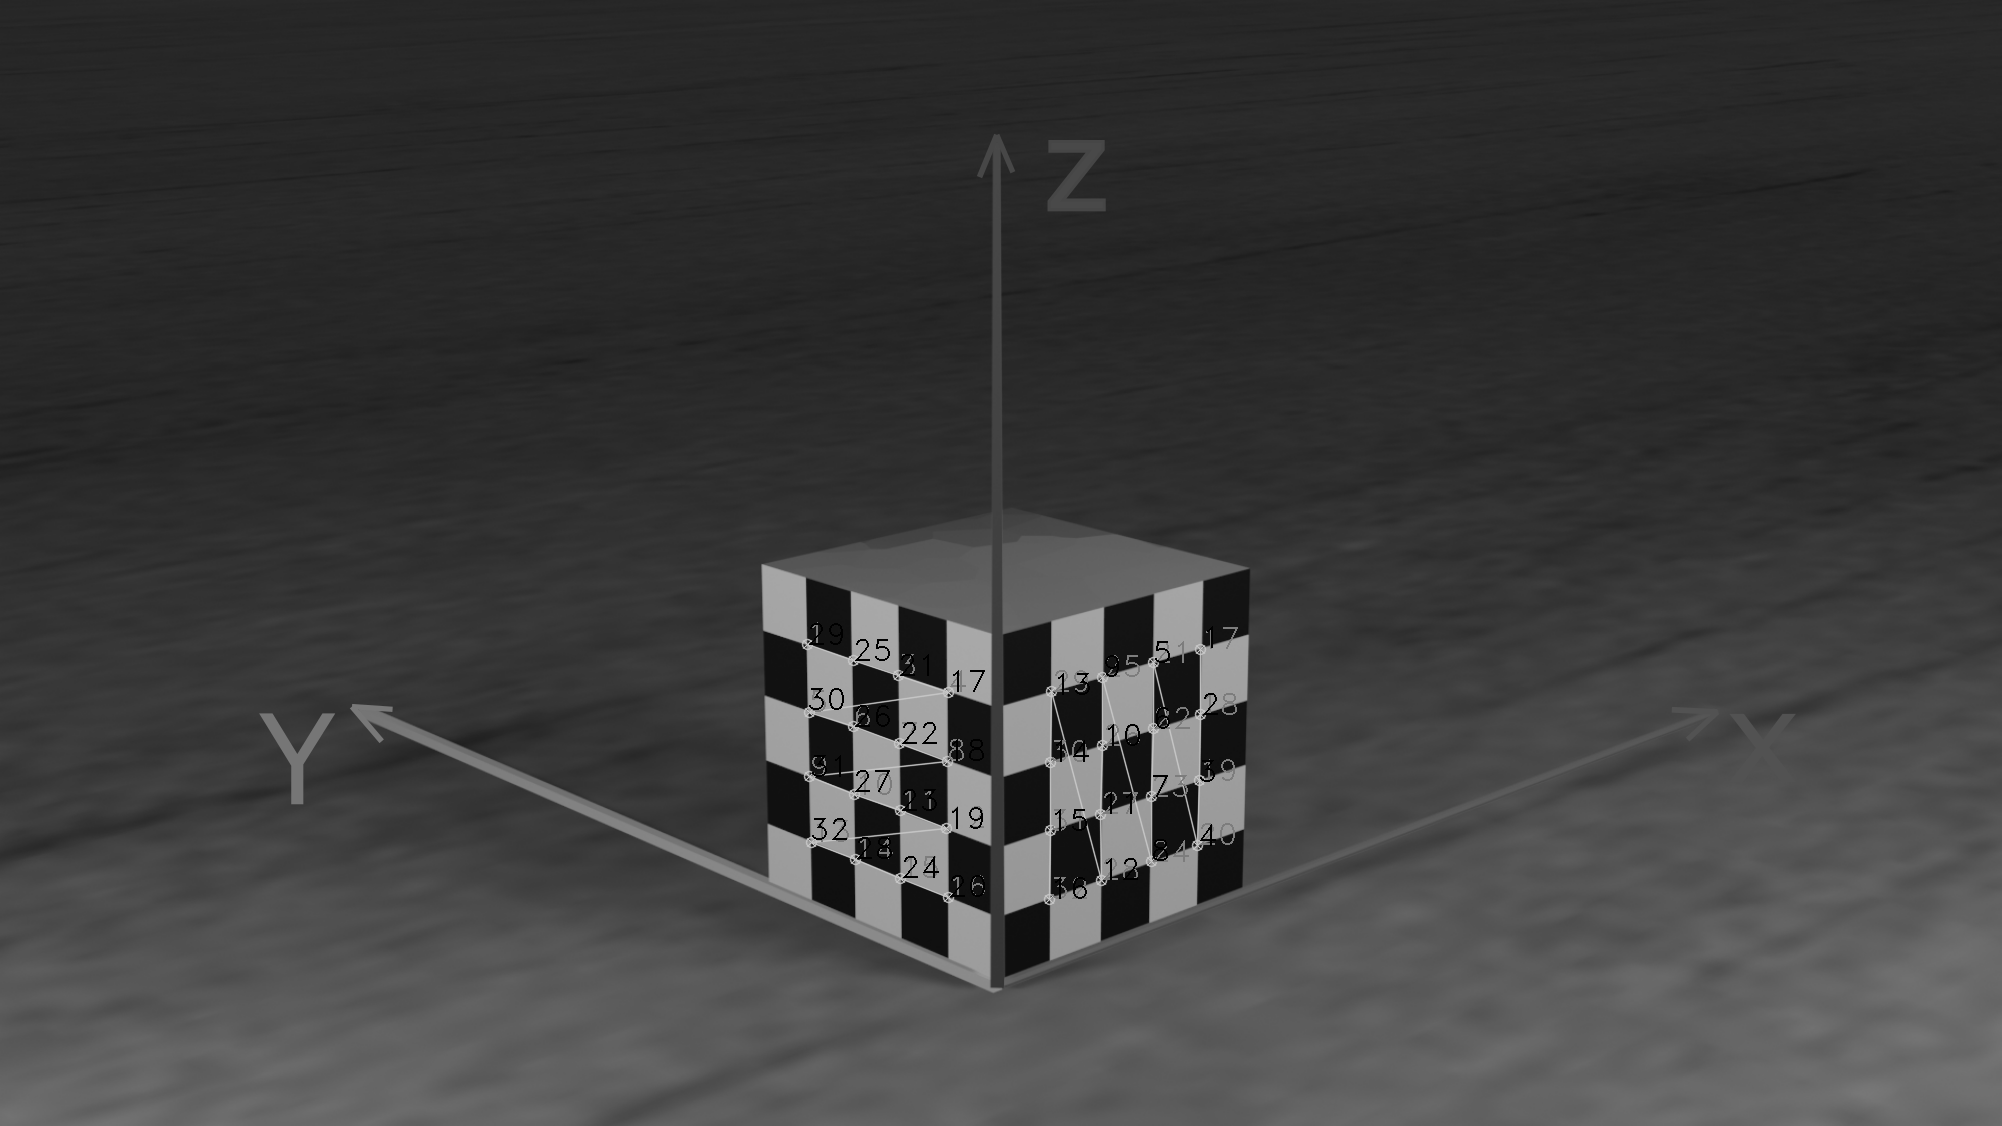

In [ ]:
text_params = {
    'fontFace' : cv2.FONT_HERSHEY_DUPLEX,
    'fontScale' : 1,
    'color' : (0, 0, 0),
    'thickness' : 3
}
image_test = image_with_text_final.copy()

for i in range(len(full_image_corners)):
    image_test = cv2.putText(img = image_test, text = str(i+1), org = (int(full_image_corners[i][0]), int(full_image_corners[i][1])), fontFace = text_params['fontFace'], fontScale = text_params['fontScale'], color=(0,0,0), thickness = 1)

cv2_imshow(image_test)